To setup the enviorment for miniCage from Cyborg++, we use python3.11 since mandy depdencies in Cyborg++/MiniCage aren't tested in  newer version of python.

First we install homebrew to install python 3.11

```
/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"
brew update
brew install python@3.11
```

Then we verify that we have the right python version and create a virtual enviroment for cyborg++

```
# sanity check: 3.11.x
/usr/local/opt/python@3.11/bin/python3.11 -V         

#1. create the hidden venv
python3.11 -m venv .venv    # or `python3 -m venv .venv` if your python3 is 3.11

#2. activate it
source .venv/bin/activate   # macOS / Linux (zsh)

#3. upgrade pip and basic build tools
python -m pip install --upgrade "pip==24.2" setuptools wheel
pip install --upgrade pip

#4. Go to mini_Cage folder and install dependencies
pip install -r requirements.txt

```



This is the challenge 2 network

![Figure 1: CAGE2 CybORG Network Diagram. The orange dotted line indicates that it is the same firewall between the User subnet and Enterprise subnet. The red dotted line indicates in the case of the defender indicates that it is a host on the network but its location is not relevant. The red dotted line for User0 indicates that this is a host on the network but that the blue agent cannot interact with it.](attachment:image.png)
Figure 1: CAGE2 CybORG Network Diagram. The orange dotted line indicates that it is the same firewall between the User subnet and Enterprise subnet. The red dotted line indicates in the case of the defender indicates that it is a host on the network but its location is not relevant. The red dotted line for User0 indicates that this is a host on the network but that the blue agent cannot interact with it.
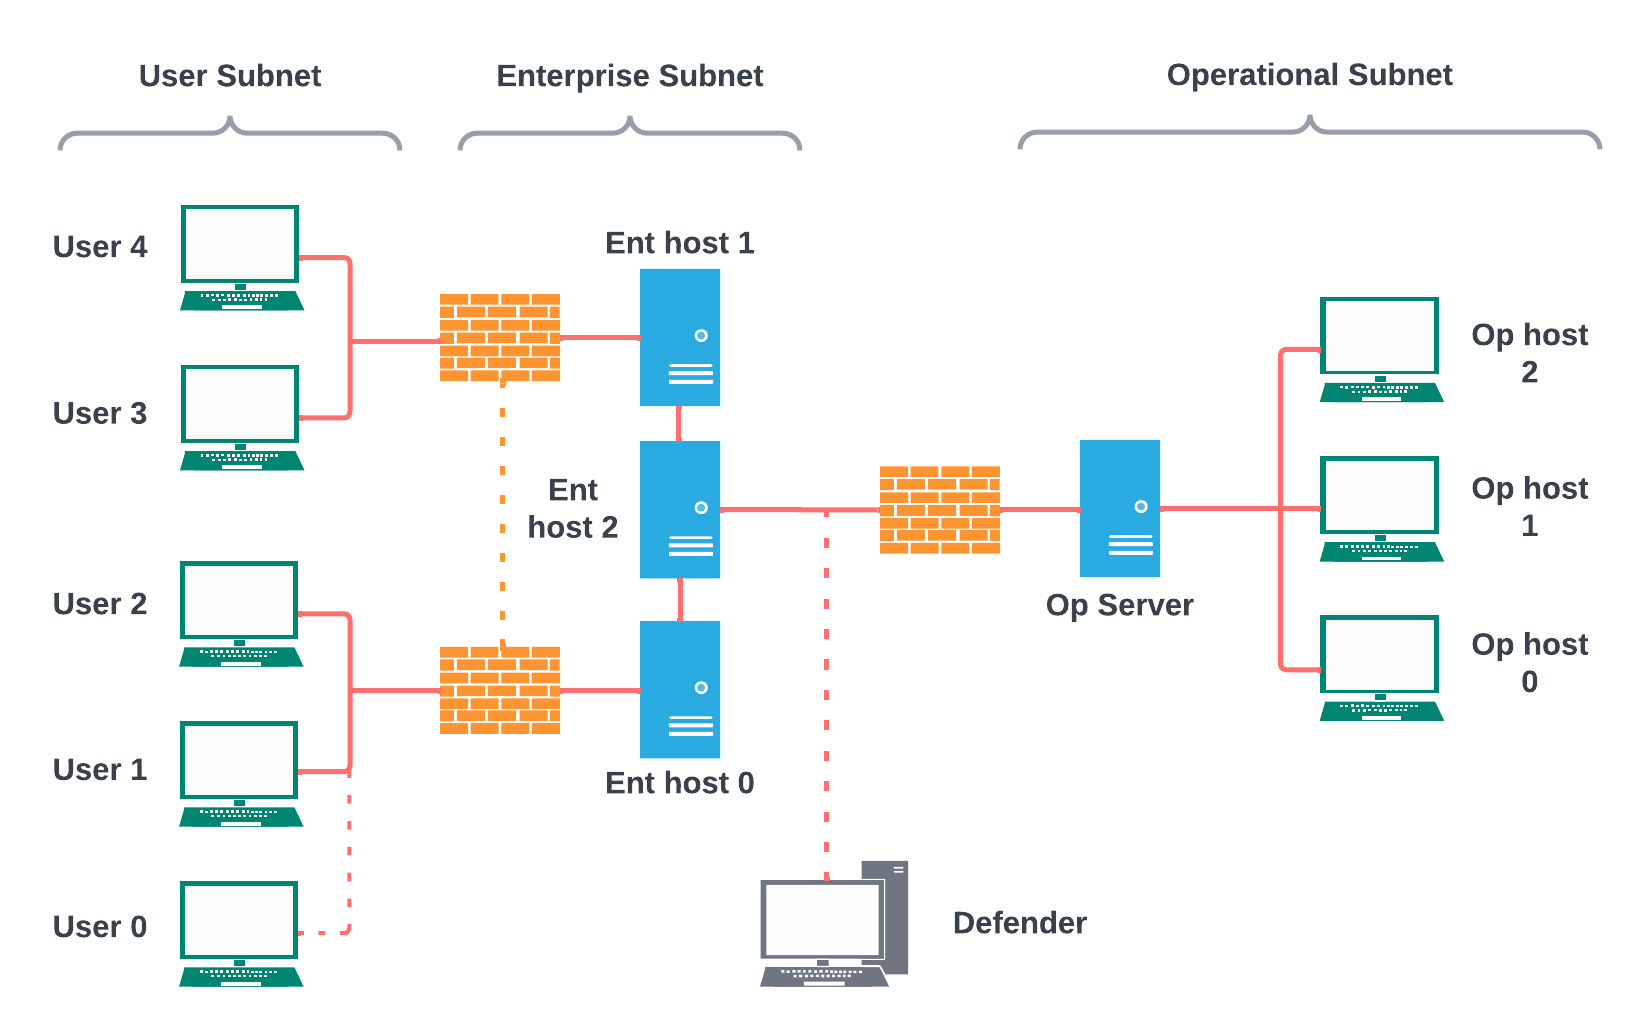

Absolutely—here’s a practical “map” of `minimal.py` so you can reason about the file without getting lost. I’ll give you:

1. the big picture (what the file is for),
2. how the step loop flows,
3. how observations & actions are encoded,
4. what the key functions do (brief one-liners), and
5. a tiny snippet you can run to auto-list every function + first docstring line for your exact copy.

---

# Big picture

`minimal.py` is the lean, fast implementation of the **MiniCAGE** environment logic. It defines:

* The **host set & topology** (e.g., `HOSTS`)
* The **environment class** (often `SimplifiedCAGE`)
* The **action mapping** for Blue/Red (index ⇄ name)
* How to **reset** and **step** the sim
* How to **encode observations** (Blue/Red vectors)
* How to **apply actions** (update state → set detections/flags → rewards)

Think of it as a compact “world simulator” that turns Blue/Red actions into new state + rewards each tick.

---

# How one step flows

A typical `env.step(blue_action, red_action)` inside `SimplifiedCAGE` does roughly:

1. **Decode actions**

   * Read the integer/array index for Blue and Red
   * Map index → action name via `action_mapping`

2. **Apply Red’s action**

   * Check Red **access & reachability** (`check_red_access`)
   * Roll **success** for the chosen attack path (`check_red_success`)
   * Update Red footholds/privilege/knowledge
   * Set **Blue-visible activity flags** (e.g., exploit detected)
   * Accrue Red/Blue/global reward contributions (e.g., OpServer impact)

3. **Apply Blue’s action**

   * E.g., `Scan`, `Monitor`, `Analyse (privileged)`, `Remove`, `Restore`, `PlaceDecoy`
   * Update host safety/compromise flags, decoys, and recent scan markers

4. **Maintenance / decay**

   * Decay “recent scan” intensity (2 → 1 after the step)
   * Clear step-activity flags (like “exploit detected this step”)

5. **Build next observations**

   * **Blue obs**: (hosts × 6) view, flattened
   * **Red obs**: per-host triplets + any global tail

6. **Compute/return rewards + done**

   * Sum reward pieces per side; set `done` when a terminal condition is met

---

# Observation encoding (crucial for interpretation)

## Blue

Length `78 = 13 hosts × 6 features/host` in your copy. Per host:

```
[ activity_scan,
  activity_exploit_detected,
  safe_flag,
  compromised_flag,
  scan_recent_0_2,   # 2 = scanned this step; decays to 1 next step
  decoys_count ]
```

We already built a helper to print this as a labeled table (you can import it if you like).

## Red

The Red vector is a set of **triplets per host** plus (optionally) a small global tail:

* Per host triplet: `[ scanned_flag, known_or_user_flag, privileged_flag ]`
  (known_or_user_flag is `-1/0/1` → unknown / known-no-access / user-or-higher)

Total triplet length = `3 × len(HOSTS)`; if your Red obs length isn’t divisible by 3, slice off the tail before calling helpers like `check_red_access`.

---

# Action mapping

`env.action_mapping` is the authoritative **index → name** dictionary (or list) for both sides:

```python
env.action_mapping['Blue'][2]  # e.g., "Restore"
env.action_mapping['Red'][3]   # e.g., "LateralMove"
```

This mapping is what turns `[[0]]` or `[[3.]]` into human-readable actions in your prints.

---

# What the key functions do (short, practical summaries)

> Names can vary a little across commits; here are the usual suspects and what they mean. If a name is missing in your file, the behavior likely exists under a nearby helper.

**Core env interface**

* `class SimplifiedCAGE(...)`: The environment object; holds state, action map, RNG, and exposes `reset()` and `step()`.
* `reset(self)`: Initialize/reset the world state; return `state, info`.
* `step(self, blue_action, red_action)`: Process both actions → update state → return `(state, reward, done, [trunc,] info)`.

**Observation builders**

* `make_blue_obs(...)` / `get_blue_obs(...)`: Build Blue’s flat vector from internal state (host × features/host).
* `make_red_obs(...)` / `get_red_obs(...)`: Build Red’s vector of per-host triplets (+ optional globals).

**Red-side helpers**

* `check_red_access(obs)`: Interpret the **Red observation** to compute:
  `known_hosts`, `scanned_hosts`, `user_access`, `privileged_access`, and per-subnet privileged flags.
  (It reshapes Red’s obs into `(B, H, 3)` triplets.)
* `check_red_success(state, red_action, ...)`: Given the decoded Red action, **determine if it succeeds** this step (reachability & RNG), **apply effects** (compromise, privilege, lateral foothold), set Blue-visible detection flags, and **add reward contributions**.
* Red action appliers (names vary): `do_recon`, `do_phish`, `do_exploit`, `do_lateral_move`, `do_privesc`, `do_exfiltrate` — these encapsulate per-action logic if the file keeps them split.

**Blue-side helpers**

* `apply_scan(...)`: Record that Blue scanned a host (set `activity_scan` and bump `scan_recent_0_2` to 2).
* `apply_monitor(...)`: Increase detection chance / log monitoring activity.
* `apply_analyse_privileged(...)`: Confirm/clear compromise; set `safe_flag` (and sometimes `compromised_flag`) to the “analysed” code.
* `apply_remove_processes(...)`: Attempt to clean a host; affects `safe_flag` and `compromised_flag`.
* `apply_restore(...)`: Reset/restore key services (especially OpServer); clears penalties that tick each step.
* `apply_place_decoy(...)`: Increase `decoys_count` on a host; can lead to Red “hitting a decoy”, raising detection without true compromise.

**Maintenance & encoding utilities**

* `decay_scan_marks(...)`: `scan_recent_0_2 = 2 → 1` after one step.
* `clear_activity_flags(...)`: zero out step-only activity markers (like `activity_exploit_detected`).
* `build_action_mapping(...)`: Construct the index → name dictionaries for both sides.
* `encode_reward(...)` / `compute_rewards(...)`: Sum per-host/per-goal reward pieces, including continuing penalties (e.g., OpServer compromised).

**Constants / topology**

* `HOSTS`: Ordered list of hostnames; defines the row order used for all per-host slices.
* Sometimes: subnet partition info (e.g., the first 4 hosts = subnet 1, next 4 = subnet 2, rest = subnet 3), used to compute `subnet_priv` in `check_red_access`.

---

# Call graph (mental model)

```
reset()
  ↳ init internal state (hosts, flags, decoys, rng)
  ↳ state['Blue'] = make_blue_obs(...)
  ↳ state['Red']  = make_red_obs(...)

step(blue_idx, red_idx)
  ↳ decode indices -> names with action_mapping
  ↳ # Red first (often): check_red_access(state['Red']); check_red_success(...)
  ↳ apply_red_effects(); set Blue activity flags; reward pieces
  ↳ # Blue: apply_* depending on action (scan/monitor/analyse/remove/restore/decoy)
  ↳ maintenance: decay/clear transient flags
  ↳ build next observations (Blue/Red)
  ↳ compute rewards, done
  ↳ return (state, reward, done, info)
```

---

# “List everything in my version” (run this to see *your* exact functions)

Paste this in a REPL from your repo root:

```python
import inspect, textwrap, mini_CAGE.minimal as minimal

fns = []
for name, obj in sorted(minimal.__dict__.items()):
    if callable(obj) and getattr(obj, "__module__", "").endswith("mini_CAGE.minimal"):
        if name.startswith("__"): 
            continue
        doc = (inspect.getdoc(obj) or "").strip().splitlines()
        fns.append((name, (doc[0] if doc else "")))

print("Functions in mini_CAGE.minimal:")
for n, d in fns:
    print(f"- {n}(): {d}")
```

That’ll print **every function name** in your `minimal.py` with the **first line of its docstring** (if present). It’s the quickest way to match the overview above to your exact file.

---

If you want, paste that output here and I’ll annotate each function with a one-line “what it affects” (which flags/arrays, reward pieces, and how it shows up in your Blue/Red observation tables).


Mini Cage Adapter 

The minicage adapter translates the matrix of blue observations from the enviorment into predicates that the HTN can use. 

For example, the enviroment shows a matrix for 3 hosts as: 
[[scan=0, exploit_detected=1, safe=0, compromised=1, scan_recent=2, decoys=0],
 [scan=1, exploit_detected=0, safe=1, compromised=0, scan_recent=0, decoys=1],
 [scan=0, exploit_detected=0, safe=0, compromised=0, scan_recent=0, decoys=0]]


But the HTN needs to have this as a predicate. So we use sets to describe if a host (h#) has an attribute
compromised = {h0}
scanned = {h1}
patched = {h1}

Blue observes the following from the SimplifiedCage definiton:
["activity_scan", "activity_exploit_detected", "safe_flag",
 "compromised_flag", "scan_recent_0_2", "decoys_count"]


We can change that into predicates with the following meaning:
| Column                      | What it means in MiniCAGE            | Symbolic predicate that captures it          |
| --------------------------- | ------------------------------------ | -------------------------------------------- |
| `activity_scan`             | Red recently scanned this host       | `scanned` (or “recently_scanned”)            |
| `activity_exploit_detected` | An exploit attempt was detected      | could inform `compromised` or “under_attack” |
| `safe_flag`                 | Analysis/removal indicates host safe | `patched` or “safe”                          |
| `compromised_flag`          | Believed compromised                 | `compromised`                                |
| `scan_recent_0_2`           | Recency of Blue’s scan (0,1,2)       | `scanned` (simplified to bool)               |
| `decoys_count`              | Number of decoys deployed            | (optional) `has_decoy` or part of `services` |





Red acts first, Blue acts second (within a step).